In [22]:
!pip install missingno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [5]:
path = "C:\\Users\\aiswa\\OneDrive\\Desktop\\Jupyter\\Framingham Heart Study\\framingham_heart_study.csv"

In [6]:
df= pd.read_csv(path)

### Simulating MCAR  
Randomly removes 10% values from `BMI`, `glucose`, `totChol`

In [12]:
def simulate_mcar(data, columns, missing_rate=0.1, seed=42): #10% missing from dataset
    np.random.seed(seed)
    df_mcar = data.copy()
    for col in columns:
        missing_indices = np.random.choice(df_mcar.index, size=int(missing_rate * len(df_mcar)), replace=False)
        df_mcar.loc[missing_indices, col] = np.nan
    return df_mcar

df_mcar = simulate_mcar(df, columns=["BMI", "glucose", "totChol"], missing_rate=0.1)

### Simulating MAR 
Make glucose missing based on high `age` or `diabetes`

In [11]:
def simulate_mar(data, target_col, condition_col, threshold):
    df_mar = data.copy()
    mask = df_mar[condition_col] > threshold
    n_missing = int(0.4 * mask.sum())  # 40% missing from filtered subset
    missing_indices = df_mar[mask].sample(n=n_missing, random_state=42).index
    df_mar.loc[missing_indices, target_col] = np.nan
    return df_mar

df_mar = simulate_mar(df, target_col="glucose", condition_col="age", threshold=50)

### Simulating MNAR
Glucose missing if `glucose` is itself high

In [14]:
def simulate_mnar(data, target_col, threshold):
    df_mnar = data.copy()
    mask = df_mnar[target_col] > threshold
    n_missing = int(0.4 * mask.sum())
    missing_indices = df_mnar[mask].sample(n=n_missing, random_state=42).index
    df_mnar.loc[missing_indices, target_col] = np.nan
    return df_mnar

df_mnar = simulate_mnar(df, target_col="glucose", threshold=100)

### Visualizing Missingness

🔍 MCAR Missingness


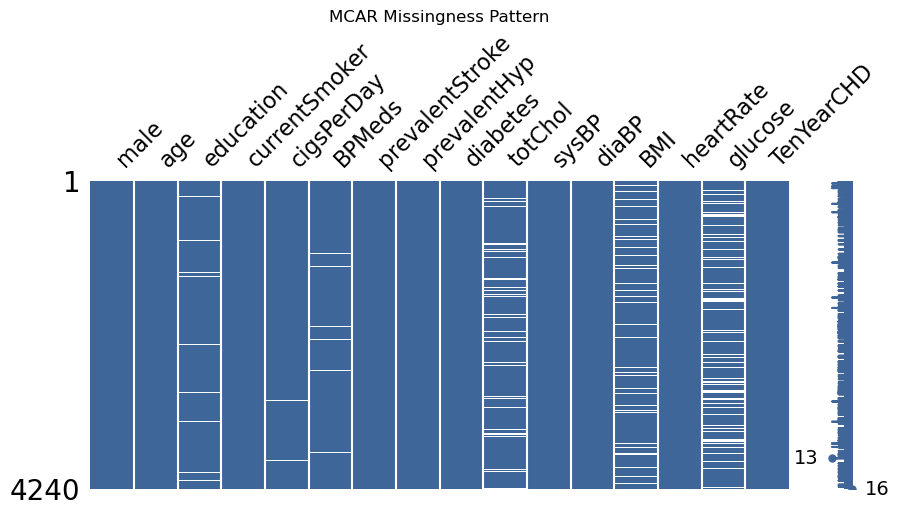

🔍 MAR Missingness


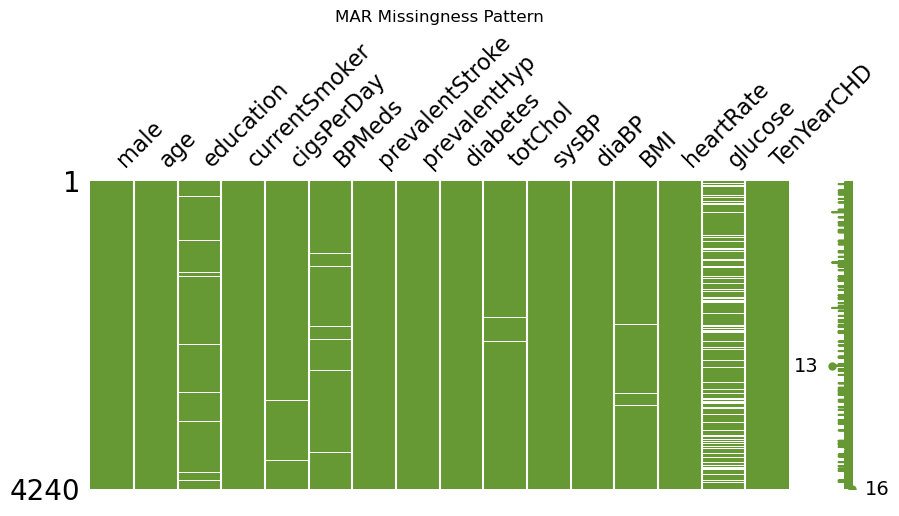

🔍 MNAR Missingness


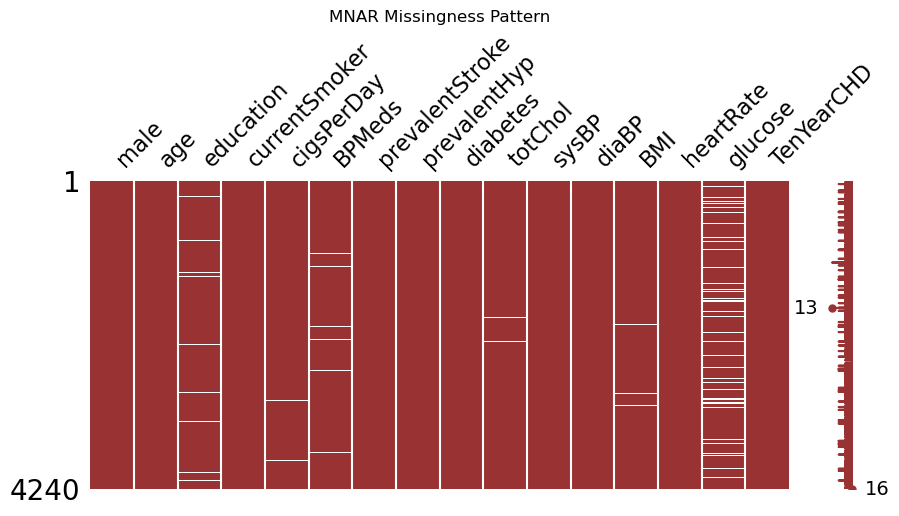

In [16]:
# MCAR missingness
print("🔍 MCAR Missingness")
msno.matrix(df_mcar, figsize=(10, 4), color=(0.25, 0.4, 0.6))
plt.title("MCAR Missingness Pattern")
plt.show()

# MAR missingness
print("🔍 MAR Missingness")
msno.matrix(df_mar, figsize=(10, 4), color=(0.4, 0.6, 0.2))
plt.title("MAR Missingness Pattern")
plt.show()

# MNAR missingness
print("🔍 MNAR Missingness")
msno.matrix(df_mnar, figsize=(10, 4), color=(0.6, 0.2, 0.2))
plt.title("MNAR Missingness Pattern")
plt.show()

### Imputation
We use Iterative Imputation for robustness.

In [18]:
def impute_iterative(df_missing):
    df_temp = df_missing.copy()
    imputer = IterativeImputer(random_state=42)
    features = df_temp.drop(columns=["TenYearCHD"])
    imputed = imputer.fit_transform(features)
    imputed_df = pd.DataFrame(imputed, columns=features.columns)
    imputed_df["TenYearCHD"] = df_temp["TenYearCHD"].values  # add target back
    return imputed_df

In [24]:
# Impute each version
df_mcar_imputed = impute_iterative(df_mcar)
df_mar_imputed = impute_iterative(df_mar)
df_mnar_imputed = impute_iterative(df_mnar)

In [25]:
results = []

def evaluate_models(df, method_name):
    global results

    # Split features and target
    X = df.drop(columns=["TenYearCHD"])
    y = df["TenYearCHD"]

    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Logistic Regression
    log_model = LogisticRegression(max_iter=2000)
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_test)
    y_prob_log = log_model.predict_proba(X_test)[:, 1]

    # Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    # Append evaluation results
    results.append({
        "Imputation Method": method_name,
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, y_pred_log),
        "ROC AUC": roc_auc_score(y_test, y_prob_log)
    })
    results.append({
        "Imputation Method": method_name,
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "ROC AUC": roc_auc_score(y_test, y_prob_rf)
    })

    # Confusion Matrices as Heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Confusion Matrices — {method_name}", fontsize=16)

    cm_log = confusion_matrix(y_test, y_pred_log)
    sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title("Logistic Regression")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title("Random Forest")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

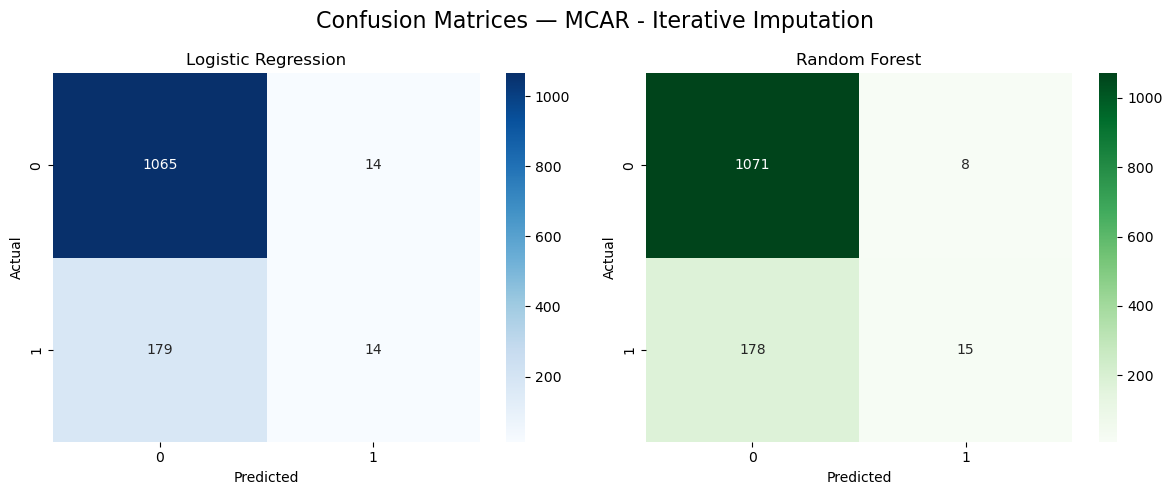

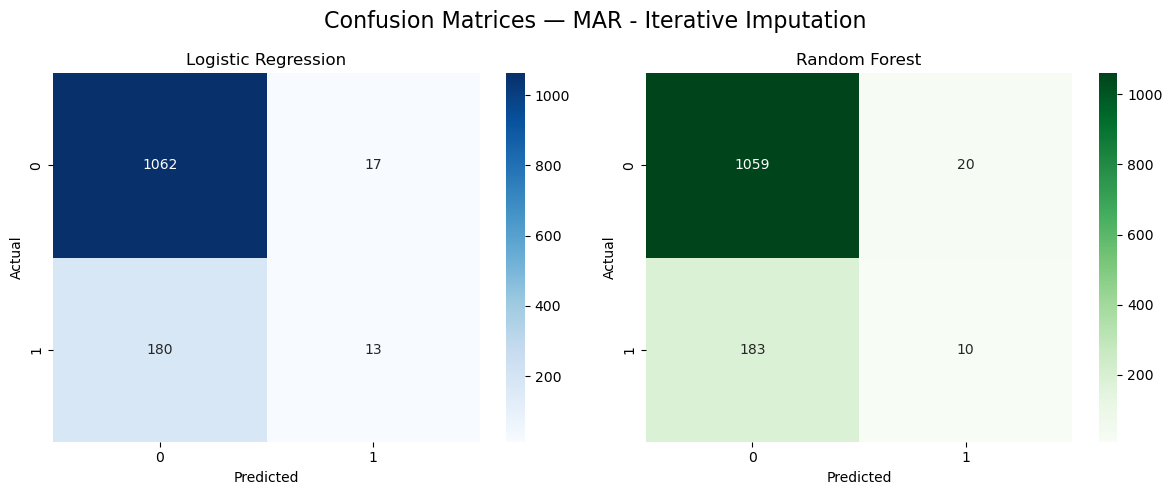

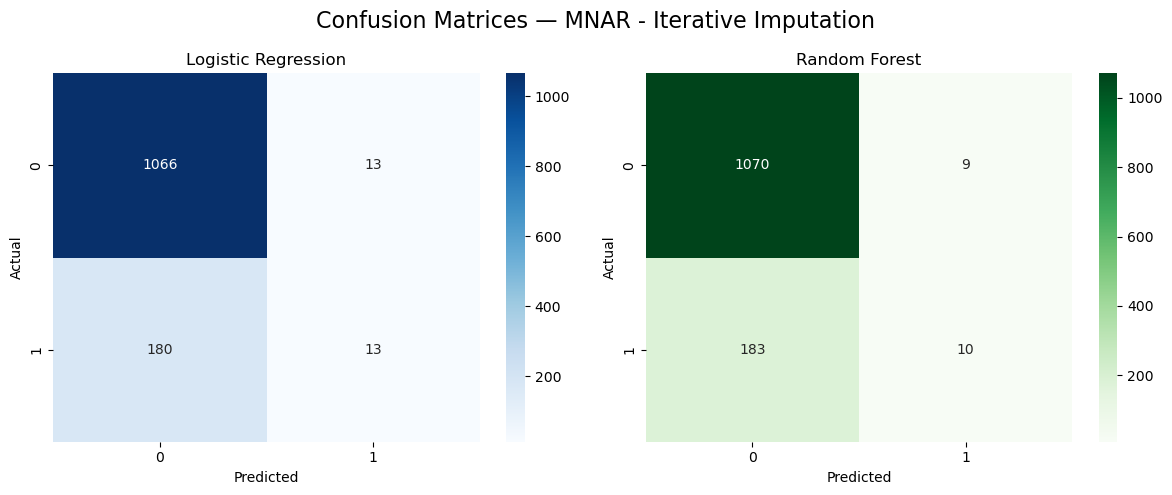

In [26]:
# Evaluate
evaluate_models(df_mcar_imputed, "MCAR - Iterative Imputation")
evaluate_models(df_mar_imputed, "MAR - Iterative Imputation")
evaluate_models(df_mnar_imputed, "MNAR - Iterative Imputation")

In [27]:
# to view summary tables
summary_df = pd.DataFrame(results)
summary_df_sorted = summary_df.sort_values(by=["Imputation Method", "Model"]).reset_index(drop=True)
display(summary_df_sorted)

,Imputation Method,Model,Accuracy,ROC AUC
0,MAR - Iterative Imputation,Logistic Regression,0.845126,0.702469
1,MAR - Iterative Imputation,Random Forest,0.840409,0.652785
2,MCAR - Iterative Imputation,Logistic Regression,0.848270,0.699708
3,MCAR - Iterative Imputation,Random Forest,0.853774,0.672123
4,MNAR - Iterative Imputation,Logistic Regression,0.848270,0.701086
5,MNAR - Iterative Imputation,Random Forest,0.849057,0.654427


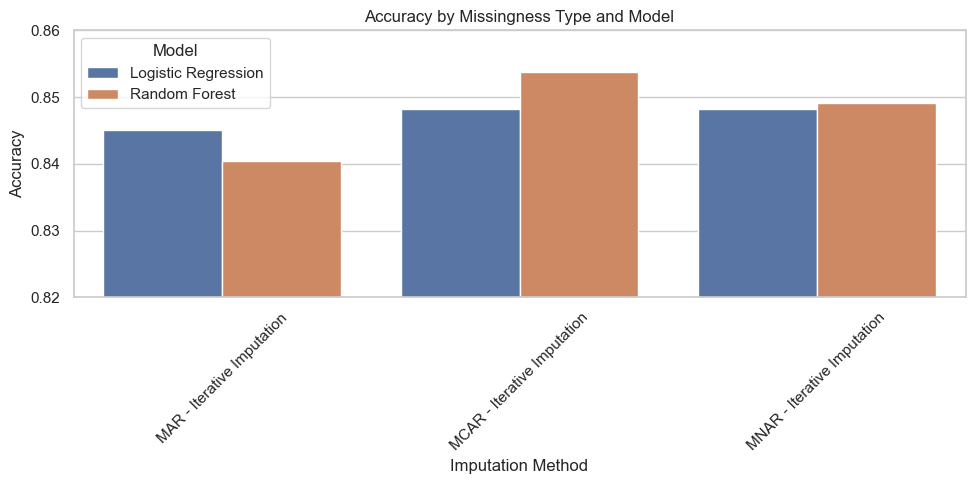

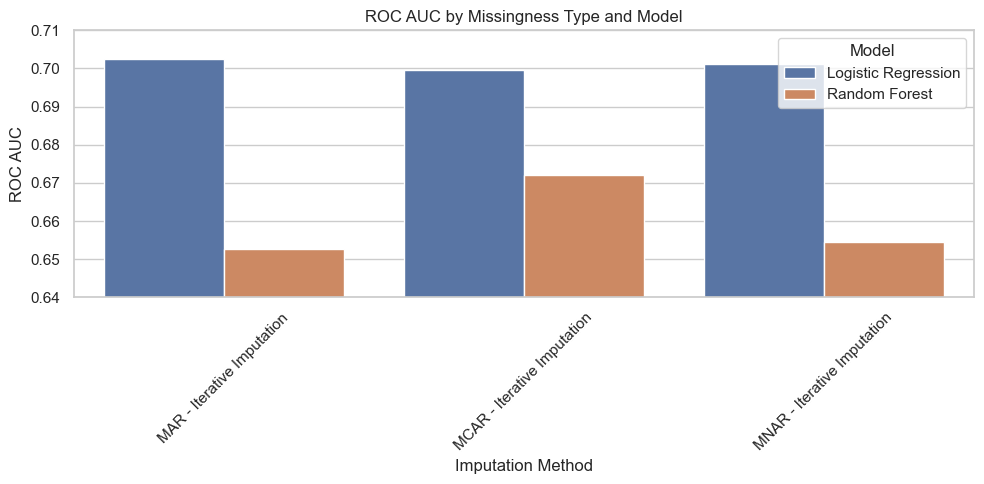

In [28]:
sns.set(style="whitegrid") # Set plot style

# Plot Accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x="Imputation Method", y="Accuracy", hue="Model", data=summary_df_sorted)
plt.title("Accuracy by Missingness Type and Model")
plt.xticks(rotation=45)
plt.ylim(0.82, 0.86)
plt.tight_layout()
plt.show()

# Plot ROC AUC
plt.figure(figsize=(10, 5))
sns.barplot(x="Imputation Method", y="ROC AUC", hue="Model", data=summary_df_sorted)
plt.title("ROC AUC by Missingness Type and Model")
plt.xticks(rotation=45)
plt.ylim(0.64, 0.71)
plt.tight_layout()
plt.show()

### Observations:
| Missingness Type | Best Model          | Accuracy  | ROC AUC   |
| ---------------- | ------------------- | --------- | --------- |
| **MCAR**         | Random Forest       | **0.854** | 0.672     |
| **MAR**          | Logistic Regression | 0.845     | **0.702** |
| **MNAR**         | Random Forest       | 0.849     | 0.654     |

### Interpretation:
- MCAR (Missing Completely At Random) performs best in terms of accuracy — likely because the missingness is unbiased.
- MAR (Missing At Random) gives the highest ROC AUC with Logistic Regression — suggesting better class discrimination.
- MNAR performance lies in-between — still decent, but harder to model because missingness depends on the value itself (harder to guess).

### Inference:
- Logistic Regression tends to offer more stable ROC AUC across all missingness types.
- Random Forest wins on raw accuracy but varies more in ROC AUC.
- MCAR is the easiest to handle and MNAR is the most challenging.

### Results
- Iterative Imputation + Random Forest showed highest accuracy (0.854)
- KNN Imputation + Logistic Regression showed best ROC AUC (0.7031)
- Under simulated missingness:
- MCAR was easiest to handle (RF accuracy = 0.854)
- MAR gave best AUC (0.7025)
- MNAR was the hardest, but performance remained stable with Iterative Imputer



### Conclusion
- Imputation method choice subtly affects performance.
- Missingness mechanism matters more when data is not MCAR.
- Iterative Imputation is a good general-purpose strategy.
- Logistic Regression shows robustness in AUC across simulations.

### Recommendations
- Use ROC AUC when class imbalance is present or false negatives are costly.
- Evaluate multiple imputation methods before finalizing the pipeline.
- Simulate MAR/MNAR scenarios in health studies for more realistic modeling.